In [1]:
# import necessary packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from datetime import datetime as dt
import numpy as np
import pandas_profiling
import math
import xarray

In [2]:
# import hurricane data from csv

hurdat = pd.read_csv(r"C:/Users/jacks/Documents/Springboard/hurricanes_capstone/HURDAT2 Data.csv")

In [ ]:
#hurdat.head()

In [ ]:
#hurdat.shape

In [ ]:
#hurdat.info()

In [3]:
# fix date column

hurdat['Date'] = pd.to_datetime(hurdat['Date'],errors='coerce',yearfirst=False)

In [4]:
# fix the name column
# remove whitespace and capitalize the first letter of each name

name_col = [name.title() for name in list(hurdat['Name'].str.lstrip())]

# create a list of names called 'new_names'
# make each 'FALSE' the preceeding name until the next name

new_names = []
name = ''

for x in name_col:
    if x != 'False':
        new_names.append(x)
        name = x
    else:
        new_names.append(name)
        
# add Storm Names column

hurdat['Storm_Name'] = new_names

# remove the Name column

hurdat.drop('Name',axis=1,inplace=True)

In [5]:
# remove rows with excessive NaN values
# without doing this I am unable to change the Year datatype

hurdat.dropna(axis=0,thresh=10,inplace=True)

In [6]:
# extract year from date column and create Year column as int datatype

hurdat['Year'] = pd.array([i.year for i in hurdat.Date], dtype='int')

In [7]:
# rearrange the columns

hurdat = hurdat.reindex(columns = ['Year','Storm_Name','Time','Date','Status','Lat','Long','Maximum sustained wind','Minimum Pressure','34 kt radii NE','34 kt radii SE','34 kt radii SW','34 kt radii NW','50 kt radii NE','50 kt radii SE','50 kt radii SW','50 kt radii NW','64 kt radii NE','64 kt radii SE','64 kt radii SW','64 kt radii NW','87 kt radii NE (est)','87 kt radii SE (est)','87 kt radii SW (est)','87 kt radii NW (est)'])

In [8]:
# make multi-index with Year and Storm_Name

hurdat = hurdat.set_index(['Year'])

In [9]:
# change column names to names easier to work with

hurdat.columns = ['Storm_Name','Time','Date', 'Status', 'Lat', 'Long', 'Max_Wind',
       'Min_Pressure', 'ne_34_kt', 'se_34_kt',
       'sw_34_kt', 'nw_34_kt', 'ne_50_kt', 'se_50_kt',
       'sw_50_kt', 'nw_50_kt', 'ne_64_kt', 'se_64_kt',
       'sw_64_kt', 'nw_64_kt', 'ne_87_kt', 'se_87_kt',
       'sw_87_kt', 'nw_87_kt']

In [10]:
# remove negative values from the radii

hurdat['ne_34_kt'].clip(lower=0, inplace=True)
hurdat['se_34_kt'].clip(lower=0, inplace=True)
hurdat['sw_34_kt'].clip(lower=0, inplace=True)
hurdat['nw_34_kt'].clip(lower=0, inplace=True)
hurdat['ne_50_kt'].clip(lower=0, inplace=True)
hurdat['se_50_kt'].clip(lower=0, inplace=True)
hurdat['sw_50_kt'].clip(lower=0, inplace=True)
hurdat['nw_50_kt'].clip(lower=0, inplace=True)
hurdat['ne_64_kt'].clip(lower=0, inplace=True)
hurdat['se_64_kt'].clip(lower=0, inplace=True)
hurdat['sw_64_kt'].clip(lower=0, inplace=True)
hurdat['nw_64_kt'].clip(lower=0, inplace=True)
hurdat['ne_87_kt'].clip(lower=0, inplace=True)
hurdat['se_87_kt'].clip(lower=0, inplace=True)
hurdat['sw_87_kt'].clip(lower=0, inplace=True)
hurdat['nw_87_kt'].clip(lower=0, inplace=True)

In [11]:
# caluculate effective radius for each wind threshold
# eff_rad_* function calculates the Effective Radius for the 4 wind thresholds
# the value output is in nautical miles

def eff_rad_34(x):
    if x['Max_Wind']>=34:
        num = (0.5*(math.sqrt((x['ne_34_kt']**2) + (x['se_34_kt']**2) + (x['sw_34_kt']**2) + (x['nw_34_kt']**2))))
        return round(num,2)

def eff_rad_50(x):
    if x['Max_Wind']>=50:
        num = (0.5*(math.sqrt((x['ne_50_kt']**2) + (x['se_50_kt']**2) + (x['sw_50_kt']**2) + (x['nw_50_kt']**2))))
        return round(num,2)

def eff_rad_64(x):
    if x['Max_Wind']>=64:
        num = (0.5*(math.sqrt((x['ne_64_kt']**2) + (x['se_64_kt']**2) + (x['sw_64_kt']**2) + (x['nw_64_kt']**2))))
        return round(num,2)
    
def eff_rad_87(x):
    if x['Max_Wind']>=87:
        num = (0.5*(math.sqrt((x['ne_87_kt']**2) + (x['se_87_kt']**2) + (x['sw_87_kt']**2) + (x['nw_87_kt']**2))))
        return round(num,2)

In [12]:
# use .apply function to create new columns

hurdat['eff_rad_34']=hurdat.apply(eff_rad_34, axis=1)
hurdat['eff_rad_50']=hurdat.apply(eff_rad_50, axis=1)
hurdat['eff_rad_64']=hurdat.apply(eff_rad_64, axis=1)
hurdat['eff_rad_87']=hurdat.apply(eff_rad_87, axis=1)

In [13]:
# change NaN values in eff_rad_* columns to 0.0

hurdat['eff_rad_34']=hurdat['eff_rad_34'].fillna(0.0)
hurdat['eff_rad_50']=hurdat['eff_rad_50'].fillna(0.0)
hurdat['eff_rad_64']=hurdat['eff_rad_64'].fillna(0.0)
hurdat['eff_rad_87']=hurdat['eff_rad_87'].fillna(0.0)

In [14]:
# count the number of Time observations that are not 0, 600, 1200, 1800

# define list of times

times = ['0','600','1200','1800']

# create a list of observations not in 'times' 

off_times = [x for x in hurdat['Time'] if x not in times]   

# find the percentage of observations with off_times

(len(off_times)/len(hurdat['Time']))*100

2.9043142926006267

In [15]:
# observe data for rows that are in 'off_times'

off_times_df = hurdat[hurdat['Time'].isin(off_times)]


# find the percentage of observations for err_rad_* in off_times_df are 0 or 999

print(str(off_times_df[off_times_df['eff_rad_34'].isin([0.00, 999.0])].eff_rad_34.count())+' / '+str(len(off_times)))

((off_times_df[off_times_df['eff_rad_34'].isin([0.00, 999.0])].eff_rad_34.count())/len(off_times))*100

93 / 241


38.589211618257266

In [16]:
# a large percentage of rows that are not at 0, 600, 1200, or 1800 have erroneous data
# remove those rows whose time is not == 0, 600, 1200, 0r 1800

hurdat = hurdat[hurdat['Time'].isin(['0','600','1200','1800'])]

In [17]:
# strip whitespace in front of statuses

hurdat.Status = hurdat.Status.str.strip()

# remove storms that aren't a tropical depression, tropical storm, or hurricane

drop_status=['EX','WV','LO','SS','SD','DB']
hurdat = hurdat[~hurdat['Status'].isin(drop_status)]
print(hurdat.Status.unique())

['TD' 'TS' 'HU']


In [18]:
# remove the N and W from the lat and long

hurdat['Lat'] = hurdat['Lat'].str.strip(to_strip='N')
hurdat['Long'] = hurdat['Long'].str.strip(to_strip='W')

In [19]:
# change the lat and long to numeric data

hurdat['Lat'] = hurdat['Lat'].astype('float64')
hurdat['Long'] = hurdat['Long'].astype('float64')

In [20]:
# convert Long coordinates to 360 degree scale

hurdat['Long'] = 359-hurdat['Long']

In [21]:
# enumerate through the columns to help slice with .iloc

print(list(enumerate(hurdat.columns)))

[(0, 'Storm_Name'), (1, 'Time'), (2, 'Date'), (3, 'Status'), (4, 'Lat'), (5, 'Long'), (6, 'Max_Wind'), (7, 'Min_Pressure'), (8, 'ne_34_kt'), (9, 'se_34_kt'), (10, 'sw_34_kt'), (11, 'nw_34_kt'), (12, 'ne_50_kt'), (13, 'se_50_kt'), (14, 'sw_50_kt'), (15, 'nw_50_kt'), (16, 'ne_64_kt'), (17, 'se_64_kt'), (18, 'sw_64_kt'), (19, 'nw_64_kt'), (20, 'ne_87_kt'), (21, 'se_87_kt'), (22, 'sw_87_kt'), (23, 'nw_87_kt'), (24, 'eff_rad_34'), (25, 'eff_rad_50'), (26, 'eff_rad_64'), (27, 'eff_rad_87')]


In [22]:
# create a new dataframe without wind columns as they are no longer necessary for creating the HSI variable

hsi = hurdat.drop(hurdat.iloc[:, 8:24], axis=1)

In [23]:
# define a function to assign intensity points

def intensity(df):
    if df['Max_Wind']<30:
        return 0
    elif df['Max_Wind']>=30 and df['Max_Wind']<=150:
        return round((df['Max_Wind']/30)**2,2)
    else:
        return 25

In [24]:
# create intensity list to insert 

intensity = list(hsi.apply(intensity, axis=1))

# insert the intensity list as Intensity_pts column

hsi.insert(8, 'Intensity_pts', intensity, True)

In [25]:
hsi.describe()

,Lat,Long,Max_Wind,Min_Pressure,Intensity_pts,eff_rad_34,eff_rad_50,eff_rad_64,eff_rad_87
count,5538.000000,5538.000000,5538.000000,5538.000000,5538.000000,5538.000000,5538.000000,5538.000000,5538.000000
mean,24.253810,296.762170,55.678043,990.046407,4.185542,75.297347,26.045479,9.945107,2.764592
std,8.265535,19.813557,26.473478,20.504170,4.346416,61.119528,33.483274,18.254421,7.988081
min,7.700000,254.000000,15.000000,882.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.125000,280.700000,35.000000,982.000000,1.360000,31.820000,0.000000,0.000000,0.000000
50%,23.900000,295.900000,50.000000,997.000000,2.780000,66.330000,10.610000,0.000000,0.000000
75%,30.700000,312.700000,70.000000,1005.000000,5.440000,111.360000,45.280000,15.000000,0.000000
max,48.800000,353.000000,160.000000,1017.000000,25.000000,415.090000,196.530000,117.150000,48.870000


In order to be able to calculate the hurricane severity we must first have winds >= 30kts to register on the Intensity 25 point scale

This means we can drop the observations with winds below 30kts

In [26]:
# drop all observations with a max wind < 30kts

hsi = hsi.loc[hsi['Max_Wind']>=30]

In [27]:
hsi.describe()

,Lat,Long,Max_Wind,Min_Pressure,Intensity_pts,eff_rad_34,eff_rad_50,eff_rad_64,eff_rad_87
count,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000,5246.000000
mean,24.196359,297.307015,57.446626,989.111132,4.418515,79.488507,27.495208,10.498666,2.918473
std,8.225277,19.484104,26.080182,20.641486,4.348960,60.086209,33.818294,18.600064,8.180016
min,7.700000,257.100000,30.000000,882.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17.200000,281.800000,35.000000,980.000000,1.360000,37.750000,0.000000,0.000000,0.000000
50%,23.800000,296.400000,50.000000,996.000000,2.780000,70.710000,15.000000,0.000000,0.000000
75%,30.500000,312.700000,70.000000,1005.000000,5.440000,114.020000,47.430000,17.320000,0.000000
max,48.800000,353.000000,160.000000,1015.000000,25.000000,415.090000,196.530000,117.150000,48.870000


In [28]:
# make a series of eff_rad_34 values without 0

print(hsi[hsi['eff_rad_34']>0].eff_rad_34.sort_values().describe())
print(hsi[hsi['eff_rad_50']>0].eff_rad_50.sort_values().describe())
print(hsi[hsi['eff_rad_64']>0].eff_rad_64.sort_values().describe())
print(hsi[hsi['eff_rad_87']>0].eff_rad_87.sort_values().describe())

count    4506.000000
mean       92.542545
std        54.727269
min         7.070000
25%        50.990000
50%        81.820000
75%       123.690000
max       415.090000
Name: eff_rad_34, dtype: float64
count    2826.000000
mean       51.040290
std        30.351606
min         3.540000
25%        28.280000
50%        45.000000
75%        67.640000
max       196.530000
Name: eff_rad_50, dtype: float64
count    1711.000000
mean       32.189363
std        19.040368
min         5.000000
25%        17.680000
50%        27.610000
75%        42.870000
max       117.150000
Name: eff_rad_64, dtype: float64
count    729.000000
mean      21.001797
std       10.088591
min        3.670000
25%       12.990000
50%       19.680000
75%       27.070000
max       48.870000
Name: eff_rad_87, dtype: float64


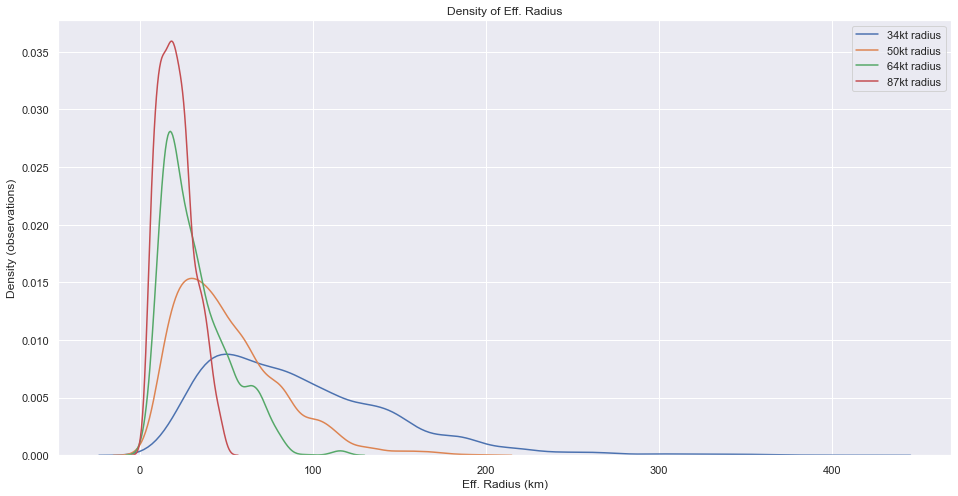

In [29]:
plt.figure(figsize=(16,8))
sns.kdeplot(data=hsi[hsi['eff_rad_34']>0].eff_rad_34, label='34kt radius')
sns.kdeplot(data=hsi[hsi['eff_rad_50']>0].eff_rad_50, label='50kt radius')
sns.kdeplot(data=hsi[hsi['eff_rad_64']>0].eff_rad_64, label='64kt radius')
sns.kdeplot(data=hsi[hsi['eff_rad_87']>0].eff_rad_87, label='87kt radius')

plt.xlabel('Eff. Radius (km)')
plt.ylabel('Density (observations)')
plt.title('Density of Eff. Radius')
plt.legend()

#plt.tight_layout
plt.show()

The range of values for 34kt effective radius is 7.07 - 415.09 and the range for intesity points for 34kt radius is 0-3. Therefore 0:7.07 and 3:408.02. Subtract 7.07 from each ratio and 0:0 and 3:408.02

To find the size points for observations of 34kt effective radius take the effective radius value, multiply it by 3, and divide by 408.02

The same calculations were performed on each respective effective radius

In [30]:
# define a function to calculate size points

def size_pts(df):
    if df['eff_rad_34']>0:
        pts_34 = 3*df['eff_rad_34']/408.02
        if df['eff_rad_50']>0:
            pts_50 = 4*df['eff_rad_50']/192.99
            if df['eff_rad_64']>0:
                pts_64 = 8*df['eff_rad_64']/112.15
                if df['eff_rad_87']>0:
                    pts_87 = 10*df['eff_rad_87']/45.2
                    return pts_34+pts_50+pts_64+pts_87     

In [31]:
# insert the Size_pts column based on the results from the size_pts function

hsi.insert(9,'Size_pts', list(hsi.apply(size_pts, axis=1)), True)

In [32]:
# replace NaN values with 0

hsi['Size_pts'].fillna(value=0, inplace=True)

In [33]:
# create Severity column by adding Intensity pts and Size pts

hsi.insert(10, 'Severity', hsi['Intensity_pts']+hsi['Size_pts'], True)

In [34]:
hsi.head()

,Storm_Name,Time,Date,Status,Lat,Long,Max_Wind,Min_Pressure,Intensity_pts,Size_pts,Severity,eff_rad_34,eff_rad_50,eff_rad_64,eff_rad_87
Year,,,,,,,,,,,,,,,
2004,Alex,1200,2004-08-01,TD,31.6,279.9,30.0,1009.0,1.00,0.0,1.00,0.00,0.00,0.0,0.0
2004,Alex,1800,2004-08-01,TS,31.6,279.8,35.0,1009.0,1.36,0.0,1.36,35.36,0.00,0.0,0.0
2004,Alex,0,2004-08-02,TS,31.5,279.7,35.0,1007.0,1.36,0.0,1.36,35.36,0.00,0.0,0.0
2004,Alex,600,2004-08-02,TS,31.4,279.6,40.0,1005.0,1.78,0.0,1.78,70.36,0.00,0.0,0.0
2004,Alex,1200,2004-08-02,TS,31.3,280.0,50.0,992.0,2.78,0.0,2.78,66.57,21.21,0.0,0.0


## Import Sea-surface Temperature (SST) Data

In [35]:
# import SST data

# convert all netCDF4 data to dataframe
# daily sea surface temperature from 2004 to 2020 for the northen Atlantic Ocean and Gulf of Mexico

sst = xarray.open_mfdataset('SST Data/*.nc4').to_dataframe()

In [37]:
# define function to complete the three actions above

idx = pd.IndexSlice
long_range = list(range(254,355))

def clean_sst(data):
    # drop lev from multiindex
    data = data.droplevel(1)
    # drop lat coordinates outside of the area of interest
    data = data.loc[7.0:49.0]
    # drop long coordinates out of the area of interest
    data = data.loc[:,(long_range),:]
    # reset the columns to a numerical index
    data = data.reset_index()
    # rename columns
    data.columns = ['Lat', 'Long', 'Date', 'SST']
    return data

In [38]:
sst = clean_sst(sst)

In [39]:
# round lat and long from hsi dataframe to the nearest whole number

# each decimal point represents about 11.1 km

hsi['Lat'] = round(hsi['Lat'])
hsi['Long'] = round(hsi['Long'])

In [40]:
sst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218484 entries, 0 to 218483
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Lat     218484 non-null  float64       
 1   Long    218484 non-null  float64       
 2   Date    218484 non-null  datetime64[ns]
 3   SST     166464 non-null  float32       
dtypes: datetime64[ns](1), float32(1), float64(2)
memory usage: 5.8 MB


In [ ]:
sst['Date'] = sst['Date'].dt.strftime('%Y-%m-%d')

In [ ]:
sst['Date'] = pd.to_datetime(sst['Date'])

In [ ]:
sst[(sst['Date']=='2004-08-02')]

## Combine the 2 dataframes

In [ ]:
complete = hsi.merge(sst, how='left', left_on=['Date','Lat','Long'], right_on=['Date','Lat','Long'])

In [ ]:
complete.head()

In [ ]:
complete.info()